# Recommender systems

## Load the dataset

We have collected food ratings from different students. The numbers have the following meaning:

Rating explanation (range from 0 to 10):	

|Rating|Description|
|-|-|
| 0	|I have never tried this food|
| 1	|I hate this food, would never eat that|
| 5	|I don't mind eating this but not a fan either|
| 10|	I absolutely LOVE this food|

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sparse_matrix = pd.read_csv('../data/food.csv', index_col='student')
sparse_matrix.drop(['age','favorite_color'], axis=1, inplace=True)
sparse_matrix

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Akbar,7,0,5,1,3,4,8,8,7
Andreas,7,7,7,0,7,3,3,5,7
Dónal,8,6,8,5,1,5,8,10,10
Hana,2,8,8,8,0,7,9,8,7
Konstantinos,7,7,1,10,10,8,10,2,7
Kristina,9,8,0,0,7,7,9,2,7
Sabrina,6,0,10,1,8,0,10,1,5
Sandrine,10,2,8,1,5,8,10,10,0
Sevgi,6,2,9,0,5,7,10,1,0


## Popularity base

In [2]:
# by ratings
(
sparse_matrix
    .reset_index()
    .melt(id_vars=['student'], value_vars=sparse_matrix.columns)
    .query('value != 0')
    .groupby('variable')
    .agg(mean_rating = ('value', 'mean'))
    .reset_index()
    .sort_values('mean_rating', ascending=False)
    .head(10)
    )

,variable,mean_rating
5,olives,8.538462
8,whisky,7.818182
2,broccoli,7.083333
4,hamburger,7.000000
7,peas,6.333333
0,onion (raw),6.000000
1,blue_cheese,6.000000
3,brussels_sprouts,5.181818
6,oysters (raw),4.111111


In [3]:
# by ratings count
(
sparse_matrix
    .reset_index()
    .melt(id_vars=['student'], value_vars=sparse_matrix.columns)
    .query('value != 0')
    .groupby('variable')
    .agg(count_rating = ('value', 'count'))
    .reset_index()
    .sort_values('count_rating', ascending=False)
    .head(10)
    )

,variable,count_rating
1,blue_cheese,13
5,olives,13
2,broccoli,12
7,peas,12
0,onion (raw),11
3,brussels_sprouts,11
4,hamburger,11
8,whisky,11
6,oysters (raw),9


In [4]:
dense_matrix = (
    sparse_matrix
    .reset_index()
    .melt(id_vars=['student'], value_vars=sparse_matrix.columns,
          var_name='item', value_name='rating')
    .rename(columns={'student':'user'})
    .query('rating != 0')
    )
dense_matrix.head()

,user,item,rating
0,Akbar,broccoli,7
1,Andreas,broccoli,7
2,Dónal,broccoli,8
3,Hana,broccoli,2
4,Konstantinos,broccoli,7


In [5]:
# create a metric based on popularity and rating
# def item_based_recommender(data: pd.DataFrame, user: str, n=5): 
def popularity_based_recommender(data: pd.DataFrame, min_n_ratings: int):

    return (
    data
        .groupby('item')
        .agg(
            mean_rating = ('rating', 'mean'),
            count_rating = ('rating', 'count')
        )
        .reset_index()
        .sort_values('mean_rating', ascending=False)
        .query('count_rating > @min_n_ratings')
        .head(10)
        )

popularity_based_recommender(dense_matrix.copy(), 11)

,item,mean_rating,count_rating
5,olives,8.538462,13
2,broccoli,7.083333,12
7,peas,6.333333,12
1,blue_cheese,6.000000,13


In [6]:
dense_matrix.head()

,user,item,rating
0,Akbar,broccoli,7
1,Andreas,broccoli,7
2,Dónal,broccoli,8
3,Hana,broccoli,2
4,Konstantinos,broccoli,7


## Item-based recommender system

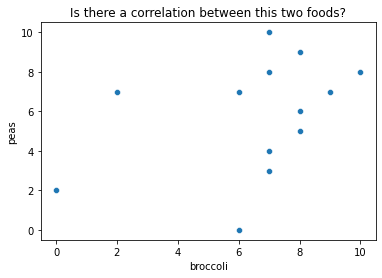

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=sparse_matrix, x='broccoli', y='peas')
plt.title('Is there a correlation between this two foods?')
plt.show()

In [8]:
sparse_matrix.corrwith(sparse_matrix['broccoli']).sort_values()

hamburger          -0.303046
blue_cheese        -0.070090
oysters (raw)      -0.063865
whisky              0.015302
 onion (raw)        0.032786
olives              0.068119
brussels_sprouts    0.182761
peas                0.389226
broccoli            1.000000
dtype: float64

## Simple function

In [9]:
def get_user_prefered_item(data: pd.DataFrame, user): 
    
    return (
    data
        .query('user == @user')
        .sort_values('rating', ascending=False)
        ['item'].tolist()[0]
        )


def get_sparse_matrix(data: pd.DataFrame): 
    
    return (
    data
        .filter(['user','item','rating'])
        .pivot('user','item','rating')
        )

def item_based_recommender(data: pd.DataFrame, item, n=6): 
    
    sparse_data = get_sparse_matrix(data)
    
    return(
    sparse_data
        .corrwith(sparse_data[item])
        .sort_values(ascending=False)
        .index
        .tolist()[1:n+1]   
    )

user = 'Joan'
prefered_item = get_user_prefered_item(data=dense_matrix, user=user)
item_based_recommender(data=dense_matrix, item=prefered_item, n=5)

['whisky', 'broccoli', 'hamburger', 'brussels_sprouts', 'oysters (raw)']

## Food chat bot

In [10]:
def chat_bot(data):
    print("Hi! I'm your personal recommender. Tell me a food that you've liked.")
    selected_item = input()
    recom = item_based_recommender(data, item=selected_item, n=1)[0]
    print(f"You will probably like {recom.replace('_',' ')}")
    
chat_bot(dense_matrix)

Hi! I'm your personal recommender. Tell me a food that you've liked.
You will probably like olives
